# Entities as Experts

This notebook is a code implementation of the paper "Entities as Experts: Sparse Memory Access with Entity Supervision" by Févry, Baldini Soares, FitzGerald, Choi, Kwiatowski.

## Problem definition and high-level model description

We want to perform question answering on typical one-shot questions that require external knowledge or context. For example, in order to answer the question "Which country was Charles Darwin born in?" one needs some text providing answers on typical structured scenarios.

In this case, however, we want to rely on knowledge-graph extracted information. For example, in the question given here, we can prune out unrelated to the antropologist and evolution theorist Charles Darwins, e.g. Charles River, Darwin City etc. 

In the paper, the authors propose to augment BERT in the task of cloze-type question answering by leveraging an Entity Memory extracted from e.g. a Knoweldge Graph.

![Entity as Experts description](images/eae_highlevel.png)

The Entity Memory is a simple bunch of embeddings of entities extracted from a Knowledge Graph. Relationships are ignored (see the Facts as Experts paper and notebook to see how they could be used).

## Datasets

> We assume access to a corpus $D={(xi,mi)}$,where all entity mentions are detected but not necessarily  all  linked  to  entities.   We  use  English Wikipedia as our corpus, with a vocabulary of 1m entities. Entity links come from hyperlinks, leading to 32m 128 byte contexts containing 17m entity links.

In the appendix B, it is explained that:

> We build our training corpus of contexts paired with entity mention labels from the 2019-04-14 dump of English Wikipedia. We first divide each article into chunks of 500 bytes,resulting in a corpus of 32 million contexts withover 17 million entity mentions. We restrict our-selves  to  the  one  million  most  frequent  entities
(86% of the linked mentions).

Given that the dump 2019-04-14 is not available at the time of writing, we will adopt the revision 2020-11-01.

Entities are thus partially extracted by link annotations (e.g. they associate with each token a mention if that token belongs to a wikipedia url).

## Mention Detection

> In addition to the Wikipedia links, we annotaten each sentence with unlinked mention spans using the mention detector from Section 2.2

The mention detection head discussed in Section 2.2 is a simple BIO sequence: each token is annotated with a B (beginning), I (inside) or O (outside) if they are respectivelly beginning, inside or outside of a mention. The reason why we use both BIO and EL is to avoid inconsistencies.

There is a catch. In the paper, they explain they used Google NLP APIs to perform entity detection and linking on large-scale Wikipedia entries, that is, to have a properly annotated Wikipedia dataset. We are going to use simple Wikipedia hyperlinks insteal (TODO: consider adding spacy annotation?).

NOTE FOR MYSELF: We don't *actually* perform entity linking here - as in, we don't train a classifier from the first $l_0$ layers. Instead we'll build pseudo embeddings and try to find the entity that best matches a pseudo embedding (see later).

HOWEVER, we do need that when training. The whole idea is that we get supervised data when training, however it is not always the case that we have this data at hand (see: TriviaQA, WebQuestions, ...).

## Entity Memory

The idea is pretty simple: we have as input $X_1$ and the mention spans $m_i = (e_i, s_{m_i}, t_{m_i})$ . Those are given as input. We don't care about e_i for the embedding calculation, but we DO care for the loss definition.

(Glossing over the Entity Memory calculation...)

When the entity detection is supervised, our obtained entity should be close to the found pseudo entity embedding.

$$
ELLoss = \sum_{m_i} \alpha_i \cdot \mathbb{1}_{e_{m_i} \ne e_{\emptyset}} , \qquad \alpha = softmax(E \cdot h_{m_i})
$$

($E$ is our `EntEmbed`, so $E * h_{m_i}$ is a vector, so $\alpha$ is a vector too (of shape $N$), and $h_{m_i}$ is a "pseudo entity embedding" ).

## Chunking
- In theory we should split articles by chunks of 500 bytes (assuming unicode encoding), and contexts are only 128 tokens long. For simplicity by now we only limit ourselves to the first paragraph only.

## Tokenization:

- BERT Tokenizer (e.g. Wordpiece) using lowercase vocabulary, limited to 128 distinct word-piece tokens.

## Learning hyperparameters

For pretraining:

> We use ADAM with a learning rate of 1e-4.  We apply warmup for the first 5% of training, decaying the learning rate afterwards.  We also apply gradient clipping with a norm of 1.0

Since the decaying rate is not provided, we test with 3e-5 which seems quite standard.

## Evaluation

To evaluate:

- TriviaQA
- MetaQA
- (Colla?)

#### Wikipedia

In [1]:
from tools.dataloaders import WikipediaCBOR, BIO

In [2]:
wikipedia_cbor = WikipediaCBOR("wikipedia/car-wiki2020-01-01/enwiki2020.cbor", "wikipedia/car-wiki2020-01-01/partitions",
                                       # top 2% most frequent items,  roughly at least 100 occurrences, with a total of  ~ 20000 entities
                                       #cutoff_frequency=0.02, recount=True 
                                    # TODO: is this representative enough?
)

Loaded from cache


In [3]:
bio_dataset = BIO("ner.csv", 128)

Loaded from cache


In [4]:
FULL_FINETUNING=False

In [5]:
# Frankly this code looks horrible - need to delve into pytorch's dataloader tools API
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, random_split

bs = 64
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    print(torch.cuda.get_device_name(0))

if not FULL_FINETUNING:
    # use only 1%  of our dataset.
    wiki_use_size = int(0.01 * len(wikipedia_cbor))
    wikipedia_cbor_limited, _ = random_split(wikipedia_cbor,
                                             [wiki_use_size, len(wikipedia_cbor) - wiki_use_size],
                                             generator=torch.Generator().manual_seed(42))
    
    wiki_train_size = int(0.8*len(wikipedia_cbor_limited))
    wiki_validation_size = len(wikipedia_cbor_limited) - wiki_train_size
    
    wikipedia_cbor_train, wikipedia_cbor_validation = random_split(wikipedia_cbor_limited,
                                                                   [wiki_train_size, wiki_validation_size], generator=torch.Generator().manual_seed(42))

else:
    wiki_train_size = int(0.8*len(wikipedia_cbor))
    wiki_validation_size = len(wikipedia_cbor) - wiki_train_size

    wikipedia_cbor_train, wikipedia_cbor_validation = random_split(wikipedia_cbor,
                                                                   [wiki_train_size, wiki_validation_size], generator=torch.Generator().manual_seed(42))

wiki_train_sampler = RandomSampler(wikipedia_cbor_train)
wiki_train_dataloader = DataLoader(wikipedia_cbor_train, sampler=wiki_train_sampler, batch_size=bs)

wiki_validation_sampler = RandomSampler(wikipedia_cbor_validation)
wiki_validation_dataloader = DataLoader(wikipedia_cbor_validation, sampler=wiki_validation_sampler, batch_size=bs)

TITAN RTX


In [6]:
bio_data = bio_dataset.get_pytorch_dataset()

bio_train_size = int(0.7 * len(bio_data))
bio_validation_size = len(bio_data) - bio_train_size

bio_train, bio_validation = random_split(bio_data, [bio_train_size, bio_validation_size])

bio_train_sampler = RandomSampler(bio_train)
bio_train_dataloader = DataLoader(bio_train, sampler=bio_train_sampler, batch_size=bs)

bio_validation_sampler = RandomSampler(bio_validation)
bio_validation_dataloader = DataLoader(bio_validation, sampler=bio_validation_sampler, batch_size=bs)

## Model

In the paper, the authors explain they used a modified BERT.

### Load and finetune the model

In [7]:
from torch.nn import Module, Linear, Dropout
from transformers.modeling_bert import BertEncoder, BertModel, BertForTokenClassification
from copy import deepcopy

class TruncatedEncoder(Module):
    def __init__(self, encoder: BertEncoder, l0: int):
        super().__init__()
        __doc__ = encoder.__doc__
        self.encoder = deepcopy(encoder)
        
        self.encoder.layer = self.encoder.layer[:l0]
        
    def forward(self, *args, **kwargs):
        __doc__ = self.encoder.forward.__doc__
        return self.encoder(*args, **kwargs)

class TruncatedModel(Module):
    def __init__(self, model: BertModel, l0: int):
        super().__init__()
        self.model = deepcopy(model)
        self.model.encoder = TruncatedEncoder(self.model.encoder, l0)
    
    def forward(self, *args, **kwargs):
        __doc__ = self.model.forward.__doc__
        return self.model(*args, **kwargs)

class BioClassifier(Module):
    """
    BIO classifier head
    """
    def __init__(self,  bertmodel: TruncatedModel):
        super().__init__()
        self.bert = bertmodel
        self.dropout = Dropout(p=0.1)
        self.classifier = Linear(in_features=768, out_features=4, bias=True)
        self.num_labels = 4
    
    def forward(self, *args, **kwargs):
        __doc__ = BertForTokenClassification.forward.__doc__
        return BertForTokenClassification.forward(self, *args, **kwargs)
    
class LinkPredictorClassifier(Module):
    """
    Link predictor classifier head. Unused.
    """
    def __init__(self,  bertmodel: TruncatedModel):
        super().__init__()
        self.bert = bertmodel
        self.dropout = Dropout(p=0.1)
        self.classifier = Linear(in_features=768, out_features=wikipedia_cbor.max_entity_num, bias=True)
        self.num_labels = wikipedia_cbor.max_entity_num
    
    def forward(self, *args, **kwargs):
        __doc__ = BertForTokenClassification.forward.__doc__
        return BertForTokenClassification.forward(self, *args, **kwargs)


### Load/save previously trained models

In [8]:
from tools.dumps import get_filename_path, is_file

# FIXME: hardcoded paths
common_model_path = get_filename_path("eae/common_model.pt")
bioclassifier_path = get_filename_path("eae/bioclassifier.pt")

def save_models(**kwargs):
    """
    Save the models
    
    >>> save_models(common_model=common_model, bioclassifier= bioclassifier)
    
    All the kwarg parameters must be `Model`s.
    """
    
    for k, v in kwargs.items():
        path = get_filename_path(f"eae/{k}.pt")
        torch.save(v.state_dict(), path)
    
def load_models():
    """
    Load the models
    """
    
    model = torch.hub.load('huggingface/pytorch-transformers',
                            'model', 'bert-base-uncased')
    
    common_model = TruncatedModel(model, l0).to(device)
    bioclassifier = BioClassifier(common_model).to(device)
    
    common_model.load_state_dict(torch.load(common_model_path))
    common_model.to(device)
    bioclassifier.load_state_dict(torch.load(bioclassifier_path))
    bioclassifier.to(device)
    
    return {"common_model": common_model, "bioclassifier": bioclassifier}

l0 = 4
if is_file("eae/bioclassifier.pt"):
    models = load_models()
    common_model = models["common_model"]
    bioclassifier = models["bioclassifier"]
    print("Correctly loaded pre-trained models.")
    del models
else:
    print("Pretrained models not found. You need to run the cells below.")
    common_model = TruncatedModel(model, l0).to(device)
    bioclassifier = BioClassifier(common_model).to(device)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


Correctly loaded pre-trained models.


In [9]:
#FULL_FINETUNING = True

def get_optimizer(model):
    """
    Get an optimizer
    """
    param_optimizer = list(model.named_parameters())

    from transformers import AdamW

    if FULL_FINETUNING:
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]

    return AdamW(
        optimizer_grouped_parameters,
        lr=1e-4,
        eps=1e-8
    )

from transformers import get_linear_schedule_with_warmup

max_grad_norm = 1.0

epochs_bio = 1 # Seems to overfit after 1 epoch

def get_schedule(epochs, optimizer, train_dataloader):
    total_steps = len(train_dataloader) * epochs

    return get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.05*total_steps),
        num_training_steps=total_steps
    )

optimizer_bio = get_optimizer(bioclassifier)
scheduler_bio = get_schedule(epochs_bio, optimizer_bio, bio_train_dataloader)

In [10]:
from seqeval.metrics import f1_score, accuracy_score

import numpy as np
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

In [21]:
from torch.nn import Module, Embedding, Dropout, ModuleList, Linear
import torch.nn as nn
import torch.nn.functional as F
import torch
import math

#GELU = torch.nn.GELU
LayerNorm = torch.nn.LayerNorm

l0 = 4
l1 = 8
    
class EntityMemory(Module):
    """
    Entity Memory, as described in the paper
    """
    def __init__(self, embedding_size: int, entity_size: int,
                   entity_embedding_size: int):
        """
        :param embedding_size the size of an embedding. In the EaE paper it is called d_emb, previously as d_k
            (attention_heads * embedding_per_head)
        :param entity_size also known as N in the EaE paper, the maximum number of entities we store
        :param entity_embedding_size also known as d_ent in the EaE paper, the embedding of each entity
        
        """
        super().__init__()
        self.N = entity_size
        self.d_emb = embedding_size
        self.d_ent = entity_embedding_size
        self.W_f = Linear(2*embedding_size, self.d_ent)
        self.W_b = Linear(self.d_ent, embedding_size)
        self.E = Linear(self.N, self.d_ent)
        self.begin = bio_dataset.bio2idx["B"]
        self.inner = bio_dataset.bio2idx["I"]
        self.out = bio_dataset.bio2idx["O"]
        
    def forward(self, X, bio_output, entities_output, k=100):
        """
        :param x the (raw) output of the first transformer block. It has a shape:
                B x N x (embed_size)
        :param entities_output the detected entities
        :param k when evaluating take the best performing K entities when supervising.
                When training this is ignored.
                
        :returns a pair (loss, transformer_output)
        """
        
        begin_positions = torch.nonzero(bio_output == self.begin)
        y = torch.zeros(X.size(0))
        loss = torch.zeros((1,))
        
        
        for pos in begin_positions:
            end_mention = pos[1]
            while end_mention < self.d_emb and bio_output[pos[0], end_mention] == self.inner:
                end_mention += 1
            end_mention -= 1


            first = X[pos[0], pos[1]]
            second = X[pos[0], end_mention]
            
            mention_span = torch.cat([first, second], 0)
            pseudo_entity_embedding = self.W_f(mention_span) # d_ent
            
            # EntEmbed in the paper
            # TODO: use a sparse representation for a OH vector
            entity_mappings_oh = torch.zeros((self.N,))
            entity_mappings_oh[entities_output[pos[0], pos[1]]] = 1
            entity_mappings = self.E(entity_mappings_oh)
            
            #if self.train:
            alpha = F.softmax(self.E.weight.T.matmul(pseudo_entity_embedding))
            
            #print(alpha.size())
            #print(self.E.weight.size())
            picked_entity = self.E.weight.matmul(alpha)
            
            #print(picked_entity.size())
            
            y[pos[0], pos[1]] = self.W_b(picked_entity)
            
            loss += alpha[entities_output[pos[0], pos[1]]]
            
        return loss, y

class Pretraining(Module):
    """
    This is a mere wrapper used to pretrain contemporarely a bio classifier and EntityMemory.
    
    We also need TokenPred but we'll ignore it at the moment.
    """
    def __init__(self, bert_first_block: TruncatedModel, bioclassifier: BioClassifier = None, *args, **kwargs):
        """
        :param bert_first_block the first block of BERT
        :param bioclassifier pass a pretrained BioClassifier here if available otherwise train
                one from scratch. Here for debugging reasons as we don't have mention detection and
                entity linking available on the same dataset (moot point - a link must imply a
                mention! - but it would cost me some work and I want to avoid it right now). If
                provided, it must rely on bert_first_block
        :see EntityMemory.__init__
        """
        super().__init__()
        self.bert = bert_first_block
        self.entity_memory = EntityMemory(*args, **kwargs)
        if bioclassifier is None:
            self.bioclassifier = BioClassifier(self.bert)
        else:
            self.bioclassifier = bioclassifier
        
    def forward(self, input_ids, attention_mask, entity_outputs):
        X = self.bert(input_ids, token_type_ids=None, attention_mask=attention_mask)
        
        # X = (last_hidden_state, tanh_output). We take the first output here.
        
        bio_outputs, = self.bioclassifier(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=None)
        
        choices = torch.argmax(bio_outputs, 2)
        
        entity_loss, entity_outputs = self.entity_memory(X[0], choices, entity_outputs)
        
        # TODO: here we need to add the second part of BERT for TokenPred
        return entity_loss, entity_outputs
    

In [22]:
mat = torch.tensor([[1, 2, 3], [4, 5, 6]])

vec = torch.tensor([1, 2, 3])

mat @ vec

tensor([14, 32])

In [23]:
embedding_size = 768 # BERT-base
entity_embedding_size = 512 # I am not sure this is a decent value but... 
pretraining_model = Pretraining(common_model, bioclassifier, embedding_size,
                                       wikipedia_cbor.max_entity_num, entity_embedding_size) \
                                      .to(device)

pretraining_epochs = 1

pretraining_optimizer = get_optimizer(pretraining_model)
pretraining_schedule = get_schedule(pretraining_epochs, pretraining_optimizer, wiki_train_dataloader)

for epoch in range(1):
    pretraining_model.train()
    
    total_loss = 0
    
    for batch in tqdm(wiki_train_dataloader):
        b_input_ids, b_attns, b_entities = tuple(b.to(device) for b in batch)
        
        pretraining_model.zero_grad()
        loss, outputs = pretraining_model(b_input_ids, b_attns, b_entities)
        loss.backward()
        total_loss += loss.item()
        
        # is this necessary?
        clip_grad_norm_(parameters=pretraining_model.parameters(),
                            max_norm=max_grad_norm)
    
        optimizer_bio.step()
        scheduler_bio.step()
        
    avg_train_loss = total_loss / len(wiki_train_dataloader)
    tqdm.write(f"Average train loss at epoch {epoch}: {avg_train_loss}")
    
    loss_values.append(avg_train_loss)
    
    pretraining_model.eval()
    
    avg_eval_loss = []
    for batch in tqdm(wiki_validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = pretrained_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        
        eval_loss += outputs[0].mean().item()
    
    avg_eval_loss.append(eval_loss)
    
    tqdm.write(f"Average eval loss at epoch {epoch}: {eval_loss}")

  0%|          | 0/110 [00:06<?, ?it/s]


IndexError: too many indices for tensor of dimension 1

In [31]:
class EaeModel(Module):
    def __init__(self,
                   first_transformer_block: TruncatedModel,
                   second_transformer_block: TruncatedModel,
                   pretrained_bioclassifier: BioClassifier,
                   pretrained_entity_memory: EntityMemory):
        """
        :param first_transformer_block the first block
        :param second_transformer_block the second transformer block (obviously)
        :param pretrained_bioclassifier a pretrained bioclassifier
                that uses first_transformer_block.
        :param task_specific_heads a head for the given problem
        """
        self.first_transformer_block = first_transformer_block
        
        # FIXME: THIS IS WRONG!
        # We do need the second part of the encoder, NOT embedder + encoder.
        self.second_transformer_block = second_transformer_block
        self.bioclassifier = trained_bioclassifier
        self.layernorm = LayerNorm(768) # TODO: make this parametric
        self.entity_memory = pretrained_entity_memory
        
        
    def forward(input_ids, attention_mask, supervised_entities):
        """
        :param input_ids the input tokens
        :param attention_mask the attention mask
        :param supervised_entities when training provide the detected entities for each token
        
        We do not apply gradient descent on the 
        """
        with torch.no_grad():
            _, bio_output = self.bioclassifier(input_ids,
                                                  token_type_ids=None,
                                                  attention_mask=attention_mask,
                                                  labels=None)
            
        # TODO: make that bio_output can return the transformer
        # output before pooling + classifying along with the outputs.
        # We could save us some time.
        
        X_2 = first_transformer_block(input_ids, token_type_ids=None,
                                attention_mask=attention_mask)
        
        # The EM loss function does not take into account W_b but we need it now.
        # Thus, we let autograd use it.
        _, X_3 self.entity_memory(X_2, bio_output, supervised_entities)
            
        self.layernorm(X_2 + X_3)
        self.second_transformer_block()
            
            

#def get_sentence_output(is_training=True, ):
#    pass

In [33]:
loss_values, validation_loss_values = [], []

for epoch in range(epochs_bio):
    bioclassifier.train()
    total_loss = 0
    
    for batch in tqdm(bio_train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        bioclassifier.zero_grad()
            
        
        outputs = bioclassifier(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        clip_grad_norm_(parameters=bioclassifier.parameters(),
                        max_norm=max_grad_norm)
    
        optimizer_bio.step()
        scheduler_bio.step()
    
    avg_train_loss = total_loss / len(bio_train_dataloader)
    tqdm.write("Average train loss: {}".format(avg_train_loss))
    
    loss_values.append(avg_train_loss)
    
    bioclassifier.eval()
    
    eval_loss, eval_accuracy = 0.0, 0.0
    number_eval_steps, number_eval_examples = 0, 0
    predictions, true_labels = [], []
    
    for batch in bio_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = bioclassifier(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        eval_loss += outputs[0].mean().item()
        
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
        
    
    eval_loss = eval_loss / len(bio_validation_dataloader)
    validation_loss_values.append(eval_loss)
    
    # flatten pred_tags and true_tags.
    #pred_tags = [[p_i for p_i in prediction] for prediction in predictions]
    #true_tags = [[t_i for t_i in truth] for truth in true_labels]
    
    
    # Padding is used only for masked values.
    pred_tags = [[bio_dataset.bio_values[p_i] for p_i, l_i in zip(p, l) if l_i != bio_dataset.bio2idx["PAD"]]
                    for p, l in zip(predictions, true_labels)]
    
    true_tags = [[bio_dataset.bio_values[l_i] for l_i in l if l_i != bio_dataset.bio2idx["PAD"]] for l in true_labels]
    
    
    tqdm.write(f"Validation Accuracy: {accuracy_score(pred_tags, true_tags)}")
    tqdm.write(f"Validation F1-Score: {f1_score(pred_tags, true_tags)}")
    tqdm.write(f"Validation loss: {eval_loss}")
    tqdm.write("")

100%|██████████| 393/393 [00:57<00:00,  6.86it/s]


Average train loss: 0.1491738242066392
Validation Accuracy: 0.9716910943073838
Validation F1-Score: 0.8803799719624213
Validation loss: 0.08271155654061475



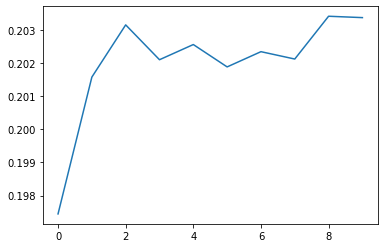

In [29]:
import matplotlib.pyplot as plt

plt.plot(validation_loss_values)

In [92]:
save_models(common_model=common_model, bioclassifier=bioclassifier)

In [ ]:

loss_values, validation_loss_values = [], []

for epoch in range(epochs):
    linkpredictorclassifier.train()
    total_loss = 0
    
    for batch in tqdm(wiki_train_dataloader):
        #batch = tuple(t.to(device) for t in batch)

        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
            
        linkpredictorclassifier.zero_grad()
        outputs = linkpredictorclassifier(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
        
        # Someone has to explain to me why someone put the loss function inside a module
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        clip_grad_norm_(parameters=linkpredictorclassifier.parameters(),
                        max_norm=max_grad_norm)
    
        optimizer_lp.step()
        scheduler_lp.step()
    
    avg_train_loss = total_loss / len(wiki_train_dataloader)
    tqdm.write("Average train loss: {}".format(avg_train_loss))
    
    loss_values.append(avg_train_loss)
    
    linkpredictorclassifier.eval()
    
    eval_loss, eval_accuracy = 0.0, 0.0
    number_eval_steps, number_eval_examples = 0, 0
    predictions, true_labels = [], []
    
    linkpredictorclassifier.eval()
    
    for batch in tqdm(wiki_validation_dataloader):
        batch = tuple([t.to(device) for t in batch])
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = linkpredictorclassifier(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        eval_loss += outputs[0].mean().item()
        
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
        
    eval_loss = eval_loss / len(wiki_validation_dataloader)
    validation_loss_values.append(eval_loss)
    
    tqdm.write(f"Validation loss: {eval_loss}")
    tqdm.write("")

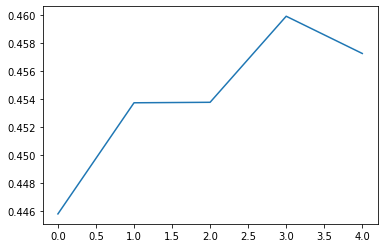

In [56]:
import matplotlib.pyplot as plt

plt.plot(validation_loss_values)

In [23]:
def transform_sentence(sentence: str):
    tokens = tokenizer.tokenize(sentence)
    print(tokens)
    padded = pad_sequences([tokenizer.convert_tokens_to_ids(tokens)], maxlen=MAX_LEN,
                  dtype="long", value=0.0, truncating="post", padding="post")
    
    attention_mask = [[float(tok != 0.0) for tok in padded_] for padded_ in padded]
    
    return padded, attention_mask

# bioclassifier.forward(tokens,)

padded, attention = transform_sentence("Hello world, this is Spongebob!")

bioclassifier.eval()
res = bioclassifier.forward(torch.tensor(padded).to(device), token_type_ids=None, attention_mask=torch.tensor(attention).to(device), labels=None)

['hello', 'world', ',', 'this', 'is', 'sponge', '##bo', '##b', '!']


NameError: name 'bioclassifier' is not defined

In [51]:
linkpredictorclassifier

LinkPredictorClassifier(
  (bert): TruncatedModel(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): TruncatedEncoder(
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOutput(
                  (dens